In [1]:
import numpy as np
from IPython.display import display

import rmgpy
from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import TemplateReaction, DepositoryReaction
from rmgpy.kinetics import KineticsData
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.species import Species
from rmgpy.thermo.thermoengine import submit

In [2]:
databasePath = rmgpy.settings['database.directory']

database = RMGDatabase()
database.load(
    path = databasePath,
    thermoLibraries = ['primaryThermoLibrary'], # can add if desired
    reactionLibraries = [], # can add if desired
    kineticsFamilies = 'default',
    kineticsDepositories = ['training'],
)

for family in database.kinetics.families.itervalues():
    family.addKineticsRulesFromTrainingSet(thermoDatabase=database.thermo)
    family.fillKineticsRulesByAveragingUp(verbose=True)

In [19]:
def find_reactions(reactant, product, n, radicals):
    """Find reactions that give the desired products."""
    reaction_list = []
    
    # Generate reactions
    if n == 1:
        # Unimolecular
        reaction_list.extend(database.kinetics.generate_reactions([reactant], [product]))
    elif n == 1.5:
        # Unimolecular with radical
        reaction_list.extend(database.kinetics.generate_reactions([reactant], [product, Species().fromSMILES('[H]')]))
    elif n == 2:
        # Bimolecular with radical
        for rad in radicals:
            reaction_list.extend(database.kinetics.generate_reactions([reactant, rad[0]], [product, rad[1]]))
    
    return reaction_list

In [22]:
pathways = [
    ('c1ccccc1CCCCCC', 'c1ccccc1[CH]CCCCC', 2),
    ('c1ccccc1[CH]CCCCC', 'c1ccccc1C=CCCCC', 2),
    ('c1ccccc1C=CCCCC', 'c1ccccc1C=CCCC[CH2]', 2),
    ('c1ccccc1C=CCCC[CH2]', 'c1ccccc1C1[CH]CCCC1', 1),
    ('c1ccccc1C1[CH]CCCC1', 'c1ccccc1C1=CCCCC1', 2),
    ('c1ccccc1C1[CH]CCCC1', 'c1ccccc1C1=CCCCC1', 1.5),
]

radicals = [
    ('[H]', '[H][H]'),
]

T = 450 + 273.15

#print 'Selected Species:'

pathway_list = []
for r, p, n in pathways:
    pathway_list.append((Species().fromSMILES(r), Species().fromSMILES(p), n))
    
#print 'Selected Radical Pool:'

rad_list = []
for a, b in radicals:
    rad_list.append((Species().fromSMILES(a), Species().fromSMILES(b)))

Searching for reactions for Step 1...
Found 2 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 1:
From:


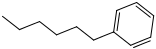

To:


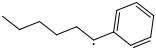

Reactions:


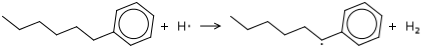

Log forward rate (m3, mol, s):  5.23565161052


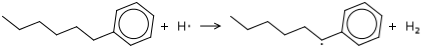

Log forward rate (m3, mol, s):  4.96175430751
Searching for reactions for Step 2...
Found 2 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 2:
From:


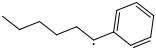

To:


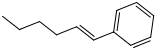

Reactions:


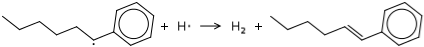

Log forward rate (m3, mol, s):  6.45848883328


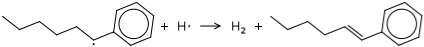

Log forward rate (m3, mol, s):  6.55870857053
Searching for reactions for Step 3...
Found 1 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 3:
From:


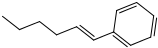

To:


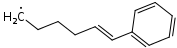

Reactions:


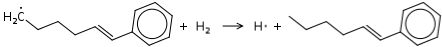

Log forward rate (m3, mol, s):  1.27346682035
Searching for reactions for Step 4...
Found 2 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 4:
From:


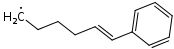

To:


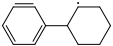

Reactions:


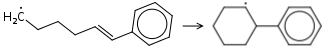

Log forward rate (m3, mol, s):  6.87585464227


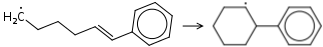

Log forward rate (m3, mol, s):  6.87585464227
Searching for reactions for Step 5...
Found 1 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 5:
From:


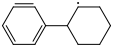

To:


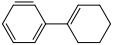

Reactions:


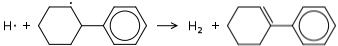

Log forward rate (m3, mol, s):  5.95616843048
Searching for reactions for Step 6...
Found 2 reactions.
Evaluating thermo and kinetics...
Adding to model core...
Results for step 6:
From:


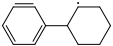

To:


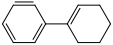

Reactions:


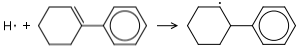

Log reverse rate (m3, mol, s):  3.19780636355


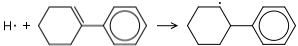

Log reverse rate (m3, mol, s):  2.7268416037


In [23]:
model = CoreEdgeReactionModel()
model.kineticsEstimator = 'rate rules'
i = 1
for r, p, n in pathway_list:
    model.newReactionList = []
    model.newSpeciesList = []
    print 'Searching for reactions for Step {0}...'.format(i)
    out = find_reactions(r, p, n, rad_list)
    print 'Found {0} reactions.'.format(len(out))
    print 'Evaluating thermo and kinetics...'
    for o in out:
        new_rxn = model.makeNewReaction(o)[0]
        model.applyKineticsToReaction(new_rxn)
        if isinstance(new_rxn.kinetics, KineticsData):
            new_rxn.kinetics = new_rxn.kinetics.toArrhenius()
        if isinstance(o, TemplateReaction) or isinstance(reaction, DepositoryReaction):
            new_rxn.fixBarrierHeight()
    
    print 'Adding to model core...'
    model.core.species.extend(model.newSpeciesList)
    model.core.reactions.extend(model.newReactionList)
    
    print 'Results for step {0}:'.format(i)
    print 'From:'
    display(r)
    print 'To:'
    display(p)
    print 'Reactions:'
    for rxn in model.newReactionList:
        display(rxn)
        if rxn.isForward:
            print 'Log forward rate (m3, mol, s): ', np.log10(rxn.kinetics.getRateCoefficient(T))
        else:
            print 'Log reverse rate (m3, mol, s): ', np.log10(rxn.generateReverseRateCoefficient().getRateCoefficient(T))
    i += 1